In [ ]:
import requests
import pandas as pd
import json
import numpy as np


# Setup pitch and plot
from mplsoccer.pitch import Pitch ,VerticalPitch

username = "XXX"
password = "XXX"


from skillcorner.client import SkillcornerClient
client=SkillcornerClient(username=username,password=password)

def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s



# 1.0 Extract the tracking data

In [ ]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the pyton client
###------------------------------------------------------------------------------------
# match_id=1886347
# client.save_match_tracking_data(match_id,
#                                 params={'data_version':3},
#                                 filepath=f'{match_id}_tracking_raw.jsonl')

####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local machine
###------------------------------------------------------------------------------------
# match_id=1886347
# raw_data=pd.read_json(f'../data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl', lines=True)

####-----------------------------------------------------------------------------------
# If you're on a separate project/environemnt
###------------------------------------------------------------------------------------
match_id=1886347
# Construct the raw GitHub URL
tracking_data_github_url=f'https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl' # Data is stored using GitLFS
raw_data=pd.read_json(tracking_data_github_url,lines=True)


# This is common
raw_df=pd.json_normalize(raw_data.to_dict('records'), 'player_data',
                         ['frame','timestamp','period','possession','ball_data'])

# Extract 'player_id' and 'group from the 'possession' dictionary
raw_df['possession_player_id'] = raw_df['possession'].apply(lambda x: x.get('player_id'))
raw_df['possession_group'] = raw_df['possession'].apply(lambda x: x.get('group'))



# (Optional) Expand the ball_data with json_normalize
raw_df[['ball_x','ball_y','ball_z','is_detected_ball']]=pd.json_normalize(raw_df.ball_data)


# (Optional) Drop the original 'possession' column if you no longer need it
raw_df = raw_df.drop(columns=['possession','ball_data'])

# Add the match_id identifier to your dataframe
raw_df['match_id']=match_id
tracking_df=raw_df.copy()
tracking_df.head()

https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/1886347/1886347_tracking_extrapolated.jsonl


,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-39.63,-0.08,51009,False,10,2025-10-07,1.0,NaN,None,0.32,0.38,0.13,True,1886347
1,-19.21,-9.18,176224,True,10,2025-10-07,1.0,NaN,None,0.32,0.38,0.13,True,1886347
2,-21.83,0.47,51649,True,10,2025-10-07,1.0,NaN,None,0.32,0.38,0.13,True,1886347
3,-1.16,-32.47,50983,True,10,2025-10-07,1.0,NaN,None,0.32,0.38,0.13,True,1886347
4,-18.88,15.73,735578,True,10,2025-10-07,1.0,NaN,None,0.32,0.38,0.13,True,1886347


# Congrats ! You have your (maybe) first tracking data frame

Now we need to get player information !

# 2.0 Extract meta data from matches

In [29]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the python client
###------------------------------------------------------------------------------------
# match_id=1886347
# raw_match_data=client.get_match(match_id)


####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local machine
###------------------------------------------------------------------------------------
# match_id = 1886347
# file_path = f'../data/matches/{match_id}/{match_id}_match.json'

# with open(file_path, 'r') as f:
#     raw_match_data = json.load(f)


####-----------------------------------------------------------------------------------
# If you're on a separate project/environment
###------------------------------------------------------------------------------------
match_id=1886347
meta_data_github_url=f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json'
# Read the JSON data as a JSON object
response = requests.get(meta_data_github_url)
raw_match_data = response.json()


# The output has nested json elements. We process them
raw_match_df=pd.json_normalize(raw_match_data,max_level=2)
raw_match_df['home_team_side']=raw_match_df['home_team_side'].astype(str)

players_df = pd.json_normalize(
    raw_match_df.to_dict('records'),
    record_path='players',
    meta=['home_team_score', 'away_team_score', 'date_time',
          'home_team_side',
         'home_team.name','home_team.id',
         'away_team.name','away_team.id'
         ], # data we keep
)


# Take only players who played and create their total time
players_df=players_df[~((players_df.start_time.isna())&(players_df.end_time.isna()))]
players_df['total_time']=players_df['end_time'].apply(time_to_seconds)-players_df['start_time'].apply(time_to_seconds)

# Create a flag for GK
players_df['is_gk']=players_df['player_role.acronym']=='GK'

# Add a flag if the given player is home or away
players_df['match_name']=players_df['home_team.name']+' vs '+players_df['away_team.name']


# Add a flag if the given player is home or away
players_df['home_away_player']=np.where(players_df.team_id==players_df['home_team.id'],'Home','Away')

# Create flag from player
players_df['team_name']=np.where(players_df.team_id==players_df['home_team.id'],players_df['home_team.name'],players_df['away_team.name'])

# Figure out sides
players_df[['home_team_side_1st_half','home_team_side_2nd_half']]=players_df['home_team_side'].astype(str).str.strip('[]').str.replace("'",'').str.split(', ', expand=True)
# Clean up sides
players_df['direction_player_1st_half']=np.where(players_df.home_away_player=='Home',players_df.home_team_side_1st_half,players_df.home_team_side_2nd_half)
players_df['direction_player_2nd_half']=np.where(players_df.home_away_player=='Home',players_df.home_team_side_2nd_half,players_df.home_team_side_1st_half)



#Clean up and keep the columns that we want to keep about

columns_to_keep=['start_time','end_time','match_name','date_time','home_team.name','away_team.name',
                'id','short_name','number','team_id','team_name','player_role.position_group','total_time',
                 'player_role.name','player_role.acronym','is_gk',
                'direction_player_1st_half','direction_player_2nd_half']
players_df=players_df[columns_to_keep]
players_df.head()

,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,00:00:00,01:25:21,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,38673,G. May,10,4177,Auckland FC,Center Forward,5121,Center Forward,CF,False,right_to_left,left_to_right
1,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51713,C. Elliott,17,4177,Auckland FC,Full Back,5400,Right Back,RB,False,right_to_left,left_to_right
2,00:00:00,01:16:37,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50951,J. Brimmer,22,4177,Auckland FC,Center Forward,4597,Center Forward,CF,False,right_to_left,left_to_right
3,00:00:00,01:24:58,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50978,C. Timmins,19,1805,Newcastle United Jets FC,Midfield,5098,Left Defensive Midfield,LDM,False,left_to_right,right_to_left
4,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,133498,F. De Vries,15,4177,Auckland FC,Full Back,5400,Left Back,LB,False,right_to_left,left_to_right


# We successfully prepared all the meta data we need for our tracking data

# 3.0 Merge Dataframes

In [30]:
# Merging datasets
enriched_tracking_data=tracking_df.merge(players_df,
                                    left_on=['player_id'],
                                    right_on=['id'])
enriched_tracking_data.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,-39.63,-0.08,51009,False,10,2025-10-07,1.0,NaN,None,0.32,...,1,1805,Newcastle United Jets FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,-19.21,-9.18,176224,True,10,2025-10-07,1.0,NaN,None,0.32,...,4,1805,Newcastle United Jets FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left
2,-21.83,0.47,51649,True,10,2025-10-07,1.0,NaN,None,0.32,...,15,1805,Newcastle United Jets FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
3,-1.16,-32.47,50983,True,10,2025-10-07,1.0,NaN,None,0.32,...,14,1805,Newcastle United Jets FC,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
4,-18.88,15.73,735578,True,10,2025-10-07,1.0,NaN,None,0.32,...,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left


# Now our data is completed

---

# 4.0 Let's see an example of how to visualize average positions, accounting for play direction

In [31]:
# Filtering for frames with a team in possession
filtered_df=enriched_tracking_data[enriched_tracking_data['possession_group'].notnull()].copy()


# We basically want to convert the X and Y to make sure we're always visualizing left to right. A player's XY will depend on the half so the straight average doesn't work

filtered_df['direction_player'] = np.where(filtered_df['period'] == 1, filtered_df['direction_player_1st_half'], filtered_df['direction_player_2nd_half'])
filtered_df['x'] = np.where(filtered_df['direction_player'] == 'right_to_left', -filtered_df['x'], filtered_df['x']) # Convert X
filtered_df['y'] = np.where(filtered_df['direction_player'] == 'right_to_left', -filtered_df['y'], filtered_df['y']) # Convert Y

# Create some flags in case we need them later
filtered_df['possession_team_name'] = np.where(filtered_df['possession_group'] == 'home team', filtered_df['home_team.name'], filtered_df['away_team.name'])
filtered_df['possession_flag'] = np.where(filtered_df['possession_team_name'] == filtered_df['team_name'], 'IP', 'OOP')


# At this point all of our players have their X and Y adjusted from left to right , so we can aggregate for across the game

aggregated_df = filtered_df.groupby(['player_id',
                                     'possession_group',
                                     'team_name',
                                     'possession_team_name',
                                     'possession_flag',  # This will allow us to check the position of the player when the team is in or out of possession
                                     'start_time', # With this we can filter in or out the players that came on as subs
                                     'number',
                                     'is_gk'])[['x', 'y']].mean().reset_index()

aggregated_df.sort_values(['possession_flag','team_name'])

# We have an aggregate by possession type !

,player_id,possession_group,team_name,possession_team_name,possession_flag,start_time,number,is_gk,x,y
1,14736,home team,Auckland FC,Auckland FC,IP,00:00:00,6,False,5.181767,-4.093078
3,23418,home team,Auckland FC,Auckland FC,IP,00:00:00,28,False,7.095420,8.334144
5,31147,home team,Auckland FC,Auckland FC,IP,01:25:21,5,False,-9.197614,0.121759
7,33697,home team,Auckland FC,Auckland FC,IP,00:00:00,4,False,-6.836360,8.199158
9,38673,home team,Auckland FC,Auckland FC,IP,00:00:00,10,False,21.607955,-0.350817
11,43829,home team,Auckland FC,Auckland FC,IP,01:09:53,25,False,15.965767,-13.335899
13,50951,home team,Auckland FC,Auckland FC,IP,00:00:00,22,False,16.022285,3.915758
23,51667,home team,Auckland FC,Auckland FC,IP,00:00:00,23,False,-7.584599,-7.521181
25,51713,home team,Auckland FC,Auckland FC,IP,00:00:00,17,False,4.349368,-18.779344
27,133498,home team,Auckland FC,Auckland FC,IP,00:00:00,15,False,6.148965,21.497048


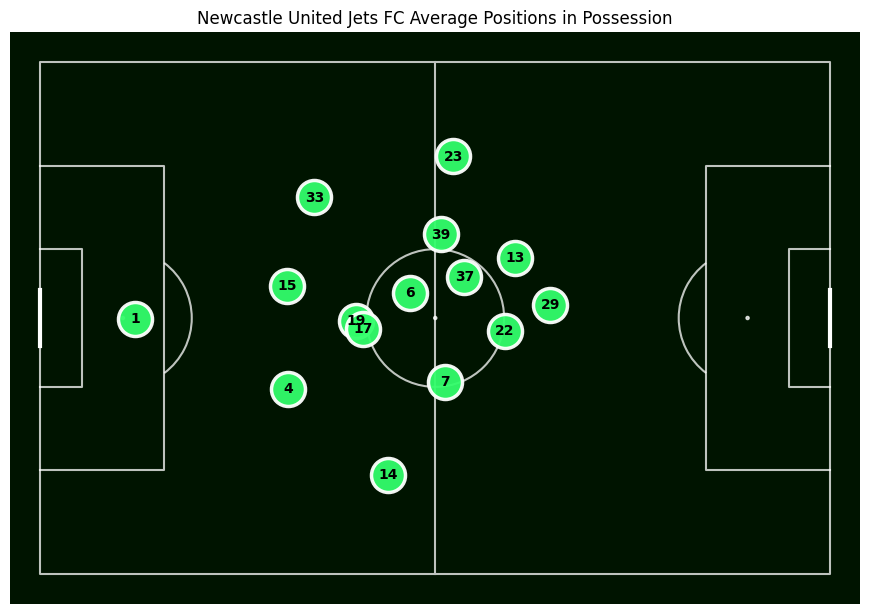

In [32]:
# Visualizing the data on a pitch

pitch = Pitch(pitch_type='skillcorner', line_alpha=0.75, pitch_length=105, pitch_width=68,
              pitch_color='#001400', line_color='white', linewidth=1.5)
fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)



# What to visualize
possession = 'IP' # or 'OOP'
team = aggregated_df.team_name.unique().tolist()[1] # Pick one team, you can use the name directly

viz_ip = aggregated_df[(aggregated_df['possession_flag'] == possession) & (aggregated_df['team_name'] == team)].reset_index(drop=True)


ax.scatter(viz_ip['x'], viz_ip['y'],
               c='#32FE6B', alpha=0.95, s=600,
               edgecolors='white', linewidths=2.5, zorder=10,label='team')


# Annotate player numbers
for i, row in viz_ip.iterrows():
    ax.text(row['x'], row['y'], str(row['number']),
            color='black', fontweight='bold', fontsize=10,
            ha='center', va='center', zorder=16)

ax.set_title(f'{team} Average Positions in Possession')

fig.savefig('my_visualised_tracking_data.png',dpi=300,format='png')

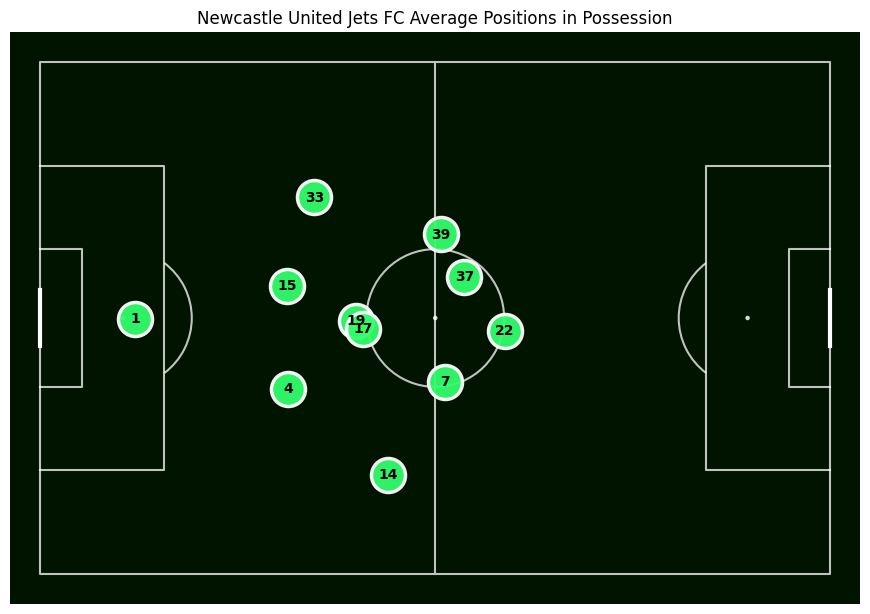

In [33]:
# Starters Onlyu

pitch = Pitch(pitch_type='skillcorner', line_alpha=0.75, pitch_length=105, pitch_width=68,
              pitch_color='#001400', line_color='white', linewidth=1.5)
fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)



# What to visualize
possession = 'IP' # or 'OOP'
team = aggregated_df.team_name.unique().tolist()[1] # Pick one team, you can use the name directly

viz_ip = aggregated_df[(aggregated_df['possession_flag'] == possession) & (aggregated_df['team_name'] == team) & (aggregated_df['start_time']=='00:00:00')].reset_index(drop=True)


ax.scatter(viz_ip['x'], viz_ip['y'],
               c='#32FE6B', alpha=0.95, s=600,
               edgecolors='white', linewidths=2.5, zorder=10,label='team')


# Annotate player numbers
for i, row in viz_ip.iterrows():
    ax.text(row['x'], row['y'], str(row['number']),
            color='black', fontweight='bold', fontsize=10,
            ha='center', va='center', zorder=16)

ax.set_title(f'{team} Average Positions in Possession')

fig.savefig('my_visualised_tracking_data_starters.png',dpi=300,format='png')